In [1]:
import psycopg2

class PostgresqlStore:
    def __init__(self):
        self.db_host = 'localhost'
        self.db_port = 5432
        self.db_user = 'postgres'
        self.db_database = 'demo'
        self.db_password = 'Like1hate_'

    def __enter__(self):
        self.conn = psycopg2.connect(database=self.db_database, host=self.db_host,
                                     port=self.db_port, user=self.db_user, password=self.db_password)
        return self

    def __exit__(self, type, value, traceback):
        self.conn.close()

In [2]:
def loadData(symbol):
    data = []
    with PostgresqlStore() as db:
        cur = db.conn.cursor()
        sql = f"SELECT tick, open, high, low, close, volume FROM candles_tick WHERE symbol='{symbol}' AND TICK > 1611316500 AND TICK < 1611360000 ORDER BY tick"
        try:
            cur.execute(sql)
            data = cur.fetchall()
        except Exception as error:
            print(error)
        cur.close()
    return data

data = loadData('THRM')

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import mplfinance as mpf
from datetime import datetime
import pandas as pd

In [4]:
plot_data = list(map(lambda x: [pd.to_datetime(int(x[0]), unit='s'), float(x[1]), float(x[2]), 
                                float(x[3]), float(x[4]), int(x[5])], data))


In [5]:
df = pd.DataFrame.from_records(plot_data)
df.columns =['datetime', 'Open', 'High', 'Low', 'Close', 'Volume'] 
df['Vwap'] = (df['Volume']*(df['High'] + df['Low'] + df['Close']) / 3).cumsum() / df['Volume'].cumsum()
df

,datetime,Open,High,Low,Close,Volume,Vwap
0,2021-01-22 14:30:00,66.63,68.20,66.63,68.16,8107,67.663333
1,2021-01-22 14:31:00,68.11,68.33,68.11,68.33,1444,67.753038
2,2021-01-22 14:32:00,68.44,68.44,68.44,68.44,109,67.760790
3,2021-01-22 14:34:00,68.42,68.42,68.35,68.35,302,67.779359
4,2021-01-22 14:35:00,68.38,68.38,68.36,68.36,351,67.799348
...,...,...,...,...,...,...,...
196,2021-01-22 20:58:00,68.53,68.53,68.44,68.44,2747,67.757168
197,2021-01-22 20:59:00,68.45,68.45,68.32,68.36,6364,67.778295
198,2021-01-22 21:00:00,68.36,68.36,68.36,68.36,37007,67.874560
199,2021-01-22 21:01:00,68.36,68.36,68.36,68.36,3536,67.882116


In [6]:
time_index = pd.DatetimeIndex(df['datetime'])
df_indexed = df.set_index(time_index)
df_plot = df_indexed.drop(['datetime'], axis=1)
#mpf.plot(df_fine, type='candle', style='charles',
#         title='THRM',
#         ylabel='Price ($)',
#         ylabel_lower='Shares \nTraded',
#         volume=True,
#         figsize=(12,8),
#         mav=(3, 6, 9))


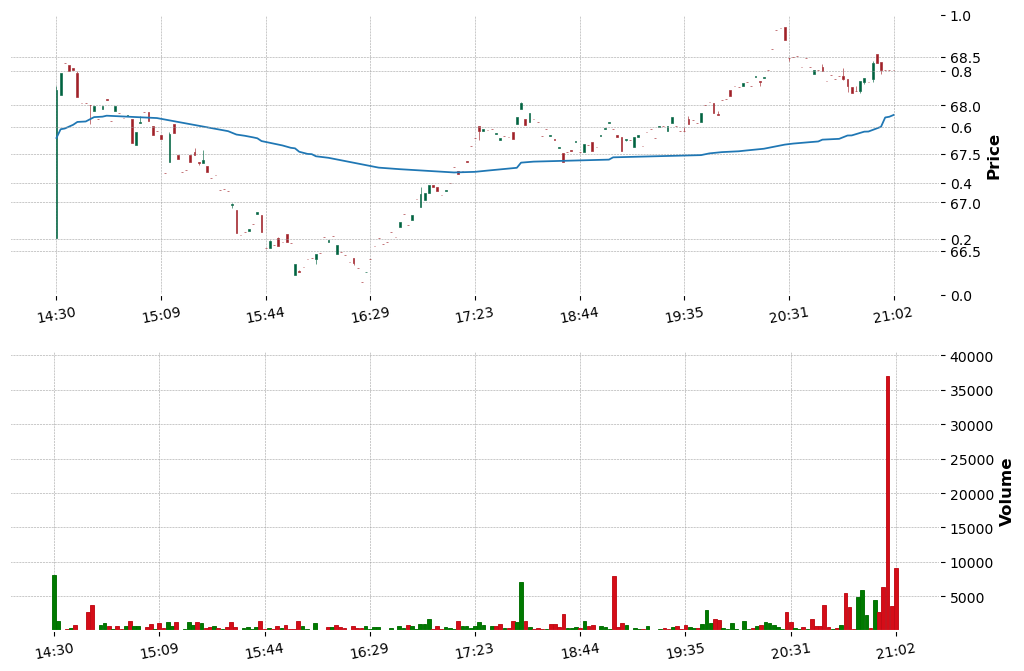

In [7]:
fig = mpf.figure(style='charles',figsize=(12,8))
ax1 = fig.add_subplot(2,1,1)
ax2 = ax1.twinx()
ax4 = fig.add_subplot(2,1,2)
ax4.yaxis.set_label_position("right")
ax4.yaxis.tick_right()
ap = mpf.make_addplot(df['Vwap'],ax=ax1,ylabel='VWAP')
mpf.plot(df_plot,ax=ax1,volume=ax4,addplot=ap,xrotation=10,type='candle')

In [8]:
daily_raw = []
with PostgresqlStore() as db:
    cur = db.conn.cursor()
    sql = "SELECT tick, open, high, low, close, volume FROM candles_tick_daily WHERE symbol='THRM' ORDER BY tick"
    try:
        cur.execute(sql)
        daily_raw = cur.fetchall()
    except Exception as error:
        print(error)
    cur.close()

In [9]:
daily_data = list(map(lambda x: [pd.to_datetime(int(x[0]), unit='s'), float(x[1]), float(x[2]), 
                                float(x[3]), float(x[4]), int(x[5])], daily_raw))
daily_df = pd.DataFrame.from_records(daily_data)
daily_df.columns =['datetime', 'Open', 'High', 'Low', 'Close', 'Volume'] 
daily_df['EWM30'] = daily_df['Close'].ewm(span = 30, adjust=False).mean()
daily_df['EWM100'] = daily_df['Close'].ewm(span = 100, adjust=False).mean()

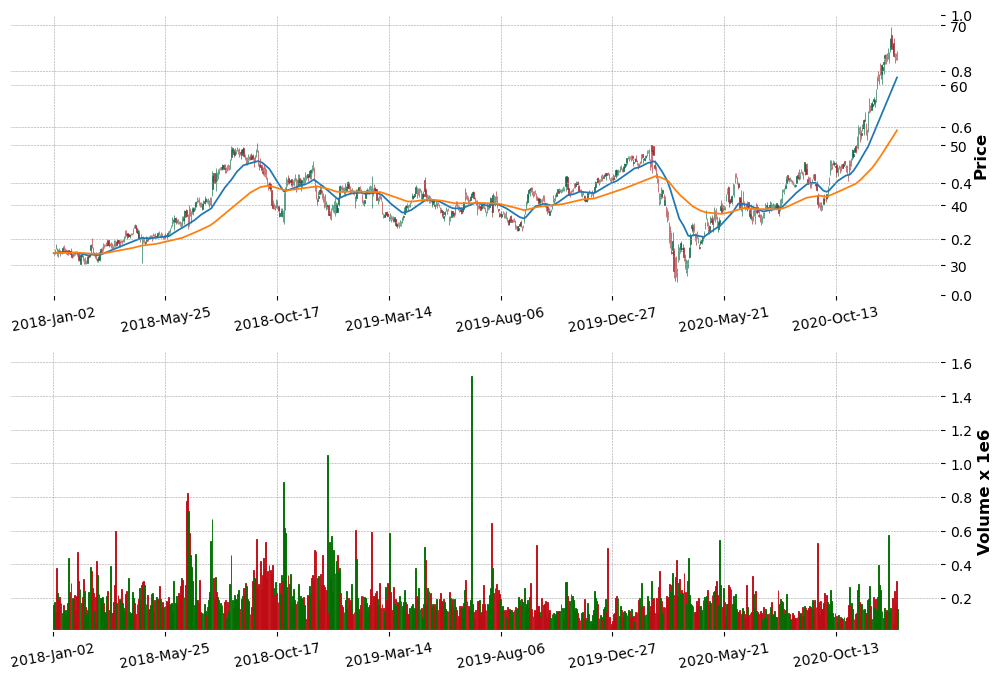

In [10]:
time_index = pd.DatetimeIndex(daily_df['datetime'])
daily_df_indexed = daily_df.set_index(time_index)
daily_df_plot = daily_df_indexed.drop(['datetime'], axis=1)
fig = mpf.figure(style='charles',figsize=(12,8))
ax1 = fig.add_subplot(2,1,1)
ax2 = ax1.twinx()
ax4 = fig.add_subplot(2,1,2)
ax4.yaxis.set_label_position("right")
ax4.yaxis.tick_right()
ap = mpf.make_addplot(daily_df_plot[['EWM30', 'EWM100']], ax=ax1)
mpf.plot(daily_df_plot, ax=ax1, volume=ax4, addplot=ap, xrotation=10, type='candle')

In [11]:
import math
from scipy import stats
prices = daily_df['Close']
daily_return = np.log(prices) - np.log(prices.shift(1))
statistic, pvalue = stats.normaltest(daily_return[1:])
if pvalue < 0.05:
    print("not normal distribution")

not normal distribution


In [12]:
def loadClosePrices(symbol):
    data = []
    with PostgresqlStore() as db:
        cur = db.conn.cursor()
        sql = f"SELECT tick, close FROM candles_tick_daily WHERE symbol='{symbol}' AND TICK > 1590969599 AND TICK < 1609372801"
        try:
            cur.execute(sql)
            data = cur.fetchall()
        except Exception as error:
            print(error)
        cur.close()
    return data

spy_data = list(map(lambda x: [pd.to_datetime(int(x[0]), unit='s'), float(x[1])], loadClosePrices('SPY')))
spy_df = pd.DataFrame.from_records(spy_data)

In [13]:
def daily_returns(symbol):
    data = list(map(lambda x: [pd.to_datetime(int(x[0]), unit='s'), float(x[1])], loadClosePrices(symbol)))
    df = pd.DataFrame.from_records(data)
    df.columns = ['date', symbol]
    prices = df[symbol]
    daily_return = np.log(prices) - np.log(prices.shift(1))
    df.drop([symbol], axis = 1)
    df[symbol] = daily_return
    return df[1:]

In [14]:
symbol_list = ['AAPL', 'BXP', 'CAT', 'DVN', 'EBAY', 'XOM', 'FLT', 'GE', 'KEY', 'MA']
daily_returns_list = list(map(lambda x: daily_returns(x), symbol_list))
from functools import reduce
daily_returns_df = reduce(lambda x, y: x.merge(y, on='date'), daily_returns_list)
print(daily_returns_df)

          date      AAPL       BXP       CAT       DVN      EBAY       XOM  \
0   2020-06-02  0.004619  0.013504  0.023133  0.038568  0.017109  0.022012   
1   2020-06-03  0.005490  0.057405  0.030113  0.029174  0.010170  0.039985   
2   2020-06-04 -0.008650  0.015063  0.014607  0.015845  0.060764 -0.002847   
3   2020-06-05  0.028083  0.050757  0.046661  0.137851 -0.011000  0.077941   
4   2020-06-08  0.005895  0.048958  0.019059  0.076454 -0.002050  0.030794   
..         ...       ...       ...       ...       ...       ...       ...   
143 2020-12-24  0.007683  0.014261  0.006369 -0.021298 -0.019951 -0.004078   
144 2020-12-28  0.035141  0.012800 -0.006649  0.001304  0.002391  0.003360   
145 2020-12-29 -0.013404 -0.019637 -0.009690 -0.002609  0.012265 -0.011324   
146 2020-12-30 -0.008563  0.006198  0.019009  0.052794 -0.006114  0.007964   
147 2020-12-31 -0.007732  0.007006  0.010938 -0.020658 -0.005952 -0.009177   

          FLT        GE       KEY        MA  
0    0.013943  0.

In [17]:
x = daily_returns_df.loc[:, symbol_list].values

from sklearn.preprocessing import StandardScaler
x = StandardScaler().fit_transform(x)
y = daily_returns('SPY')['SPY'][1:].values
finalDf = pd.DataFrame(data = principalComponent, columns = ['principal component'])
finalDf['target'] = y

<module 'pandas' from 'C:\\Users\\zhiwi\\scoop\\apps\\anaconda3\\2020.11\\lib\\site-packages\\pandas\\__init__.py'>

In [18]:
test_df = daily_returns_df.loc[:, symbol_list]
data_scaled = pd.DataFrame(preprocessing.scale(test_df),columns = test_df.columns)
pca = PCA(n_components=1)
fits = pca.fit_transform(data_scaled)
#print(data_scaled[:5])
print(pca.components_)


NameError: name 'preprocessing' is not defined

In [ ]:
finalDf['principal component'].plot(title='first principal component daily returns')

In [ ]:
finalDf['target'].plot(title='S&P 500 daily returns')